In [30]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib

In [31]:
df = pd.read_csv('Events.csv')

In [32]:
df = df[(df['t0']>0)&(df['sigmas']<0.2)&(df['sigmam']<0.15)]
#df = df[(df['run_number']==16678) &(df['event_number']==18)]

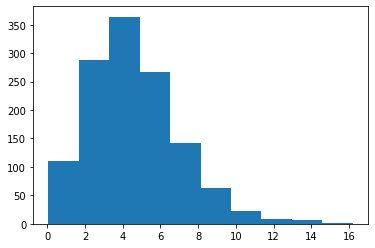

In [33]:
plt.hist(df['sigmat0'])
plt.show()

In [34]:
df.keys()

Index(['Unnamed: 0', 'Unnamed: 1', 'run_number', 'event_number', 'zenith',
       'azimuth', 'energy', 'x', 'y', 'z', 'ShowerCOG_x', 'ShowerCOG_y',
       'ShoweCOG_z', 'ShowerCOG_time', 'm', 's', 't0', 'charge', 'chargePe',
       'chargeVEM', 'chi2', 'sigmat0', 'sigmam', 'sigmas', 'feimpedance',
       'spemean', 'pe_per_vem', 'angular_resolution', 'chi2_ldf', 'chi2_time',
       'Laputop_dir_zenith', 'Laputop_dir_azimuth', 'Laputop_time',
       'Laputop_pos_x', 'Laputop_pos_y'],
      dtype='object')

In [35]:
df['energy'].unique()

array([7.07102439, 7.09307323, 7.53621147, 6.49628021, 7.79362409,
       7.78465403, 6.47373944, 6.07708739, 7.12643209, 7.30033126,
       7.37400534, 6.70153086, 6.21830842])

In [36]:
#df[df['r']>300].head()

In [37]:
r = ((df['x'].values-df['ShowerCOG_x'].values)**2.0 + (df['y'].values-df['ShowerCOG_y'].values)**2.0 + (df['z'].values-df['ShoweCOG_z'].values)**2.0)**0.5

In [38]:
for i in range(len(r)):
    if df['ShowerCOG_time'].values[i] < df['t0'].values[i]:
        r[i] = r[i]
    else:
        r[i] = -r[i]

In [39]:
df['r'] = r

In [40]:
c = .299

In [41]:
def get_delta(r,a):
    delta = a * r**2.0
    return delta

In [42]:
def get_n(x,y,z):
    x,y,z = np.array([x,y,z])/(x**2.0+y**2.0+z**2.0)**0.5
    return [x,y,z]

In [43]:
def get_t(X,x1,y1,z1,a,xc,yc,zc,tc):
    x,y,z,r = X
    n = get_n(x1,y1,z1)
    x1 = (x-xc)*n[0]
    x2 = (y-yc)*n[1]
    x3 = (z-zc)*n[2] 
    new = x1 + x2 + x3
    t = tc + (1/c)*np.array(new) #+ get_delta(r,a)
    return t

In [44]:
def get_angular_resolution(x1,y1,z1,x2,y2,z2):
    n1 = np.array(get_n(x1,y1,z1))
    n2 = np.array(get_n(x2,y2,z2))
    angular_res = np.arccos(np.dot(n1,n2))*180/np.pi
    return angular_res

In [45]:
from scipy.optimize import curve_fit

In [46]:
from functools import partial

In [47]:
events = df['Unnamed: 0'].unique()

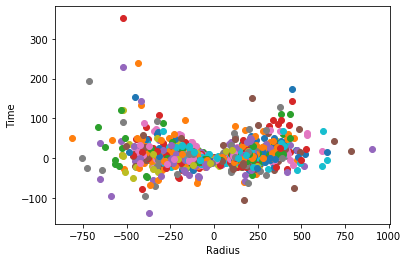

In [48]:
ang_res = []
laputop_res = []
residuals = []

for i in events:

    event1 = df.loc[df['Unnamed: 0'] == i]

    tc = event1['ShowerCOG_time'].values[0]
    xc = event1['ShowerCOG_x'].values[0]
    yc = event1['ShowerCOG_y'].values[0]
    zc = event1['ShoweCOG_z'].values[0]

    x = event1['x'].values
    y = event1['y'].values
    z = event1['z'].values
    r = event1['r'].values
    
    get_t_new = partial(get_t,tc=tc,xc=xc,yc=yc,zc=zc)

    fit = curve_fit(get_t_new,(x,y,z,r),event1['t0'].values,
                    p0=[-0.5,-0.5,-0.5,4.823*10**-4],
                    bounds=((-1,-1,-1,0),(1,1,0,np.inf)))
    true_zen = event1['zenith'].values[0]
    true_az = event1['azimuth'].values[0]
    
    true_x = -np.sin(true_zen) * np.cos(true_az)
    true_y = -np.sin(true_zen) * np.sin(true_az)
    true_z = -np.cos(true_zen)
    ang_res_fit = get_angular_resolution(fit[0][0],fit[0][1],fit[0][2],true_x,true_y,true_z)
    angular_resolution = event1['angular_resolution'].values[0]
    value = get_t_new((x,y,z,r),fit[0][0],fit[0][1],fit[0][2],fit[0][3])
    
    plt.scatter(event1['r'].values,event1['t0'].values-value)
    residuals.append(event1['t0'].values-value)
    #plt.scatter(event1['r'].values,value)

    
    ang_res.append(ang_res_fit)
    laputop_res.append(angular_resolution)
ang_res = np.array(ang_res)
laputop_res = np.array(laputop_res)
plt.xlabel('Radius')
plt.ylabel('Time')
plt.show()

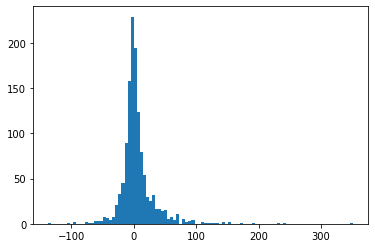

In [49]:
plt.hist(np.hstack(residuals),bins=100)
plt.show()

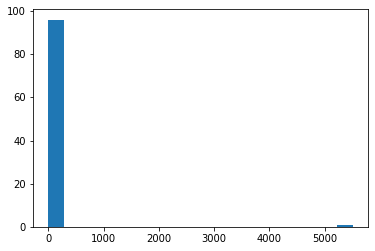

In [50]:
plt.hist(laputop_res,bins=20)
plt.show()

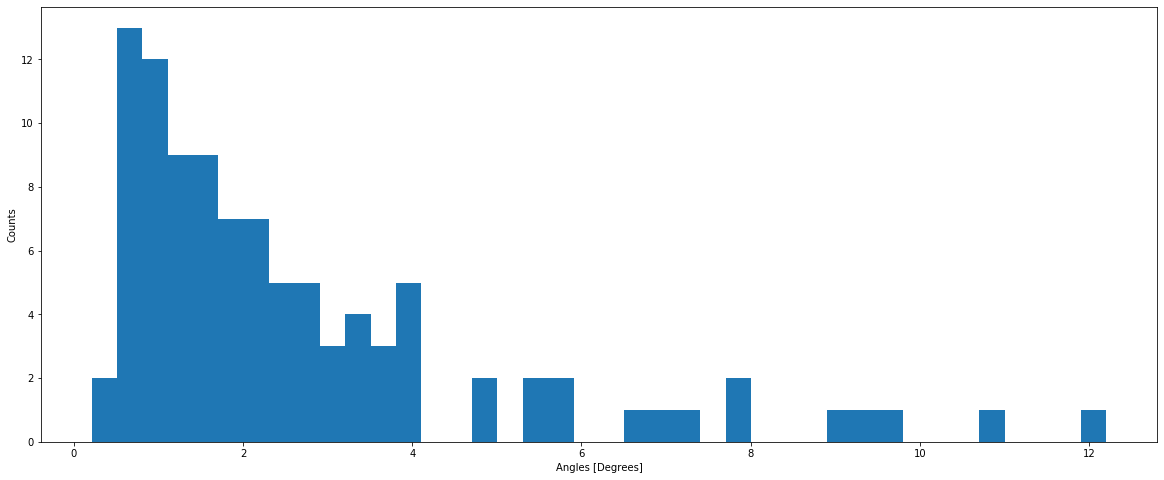

In [59]:
plt.figure(figsize=(20,8))
plt.hist(ang_res,bins=40)
plt.xlabel('Angles [Degrees]')
plt.ylabel('Counts')
plt.savefig('AngularResolution')

In [52]:
value = get_t_new((x,y,z,r),fit[0][0],fit[0][1],fit[0][2],fit[0][3])

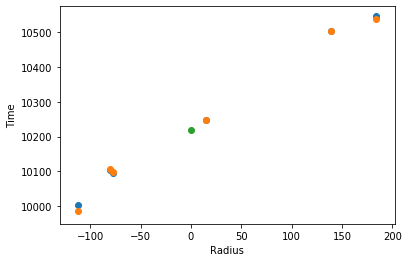

In [53]:
plt.scatter(event1['r'].values,event1['t0'].values)
plt.scatter(event1['r'].values,value)
plt.scatter(0,event1['ShowerCOG_time'].values[0])
plt.xlabel('Radius')
plt.ylabel('Time')
plt.show()

In [54]:
print(event1['ShowerCOG_time'])

4047    10217.738401
4048    10217.738401
4050    10217.738401
4051    10217.738401
4052    10217.738401
4056    10217.738401
Name: ShowerCOG_time, dtype: float64
